TODO
1. extract features by googlenet
2. compute similarity
3. test on Place dataset

In [5]:
# load places205 dataset
# import hub
# ds = hub.load("hub://activeloop/places205")
# dataloader = ds.pytorch(num_workers = 2, shuffle = False, batch_size= 4)

import numpy as np
# img = ds.images[0].numpy()
# print(img.shape)

import matplotlib.pyplot as plt
# plt.imshow(img)
# images=ds.images[0:244].numpy()

In [6]:
import torch
import torch.nn as nn
from googlenet_places205 import GoogLeNetPlaces205

model = GoogLeNetPlaces205()
model.load_state_dict(torch.load("googlenet_places205.pth"))

# define hook
features = {}
def get_middle_output(name):
    def hook(model, input, output):
        features[name] = (output.detach())
    return hook

# model.inception_3b_5x5.register_forward_hook(get_middle_output('icp1'))
model.inception_4b_5x5.register_forward_hook(get_middle_output('icp1'))

In [7]:
import os
from PIL import Image
from torchvision import transforms

def preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_batch,np.array(input_image)

def get_features(input):
    output = model(input)
    return features['icp1'].flatten()

def get_similarity(input1, input2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    return cos(input1, input2)


def process_images_from_folder(folder):
    image_features = []
    images=[]
    for filename in os.listdir(folder):
        if filename is not None:
            input,image = preprocess_singe_img(folder + '/' + filename)
            images.append(image)
            image_features.append(get_features(input))
    return image_features,images

# filename = ["images/road.png", "images/road2.png", "images/rail.png", "images/rail2.png"]
# outputs = []
# for img in filename:
#     input = preprocess(img)
#     outputs.append(get_features(input))

In [8]:
from skimage.feature import hog
from skimage import exposure
def hog_preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1),
    ])
    input_tensor = transform(input_image)
    # input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_tensor,np.array(input_image)

def get_hog_features(input):
    fd = hog(input.squeeze(), orientations=10, pixels_per_cell=(6, 6),
            cells_per_block=(1, 1))
    # print(fd.shape)
    return fd



def hog_process_images_from_folder(folder):
    image_features = []
    images=[]
    for filename in os.listdir(folder):
        if filename is not None:
            input,image = hog_preprocess_singe_img(folder + '/' + filename)
            image_features.append(get_hog_features(input))
            images.append(image)
    return image_features,images

database = "images/database"
query = "images/query"
hog_database_features,hog_database_images = hog_process_images_from_folder(database)
hog_query_features,hog_query_images =  hog_process_images_from_folder(query)

In [9]:
def visualize(database_images,query_images,similarity_matrix,query_num=10):
    matches=np.argmax(similarity_matrix,axis=1)
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize= (8,60)) 
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[matches[i]])
        ax[i, 1].set_title(matches[i])
    fig.show()


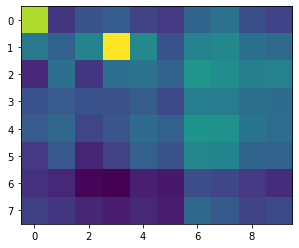

In [10]:
hog_similarity_matrix = np.zeros((len(hog_query_features), len(hog_database_features))) # Q by D

for i in range(len(hog_query_features)):
    for j in range(len(hog_database_features)):
        hog_similarity_matrix[i][j] = get_similarity(torch.from_numpy(hog_query_features[i]), torch.from_numpy(hog_database_features[j]))


plt.imshow(hog_similarity_matrix[:-2])
plt.show()

C:\Users\ranba\AppData\Local\Temp\ipykernel_4240\436049030.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


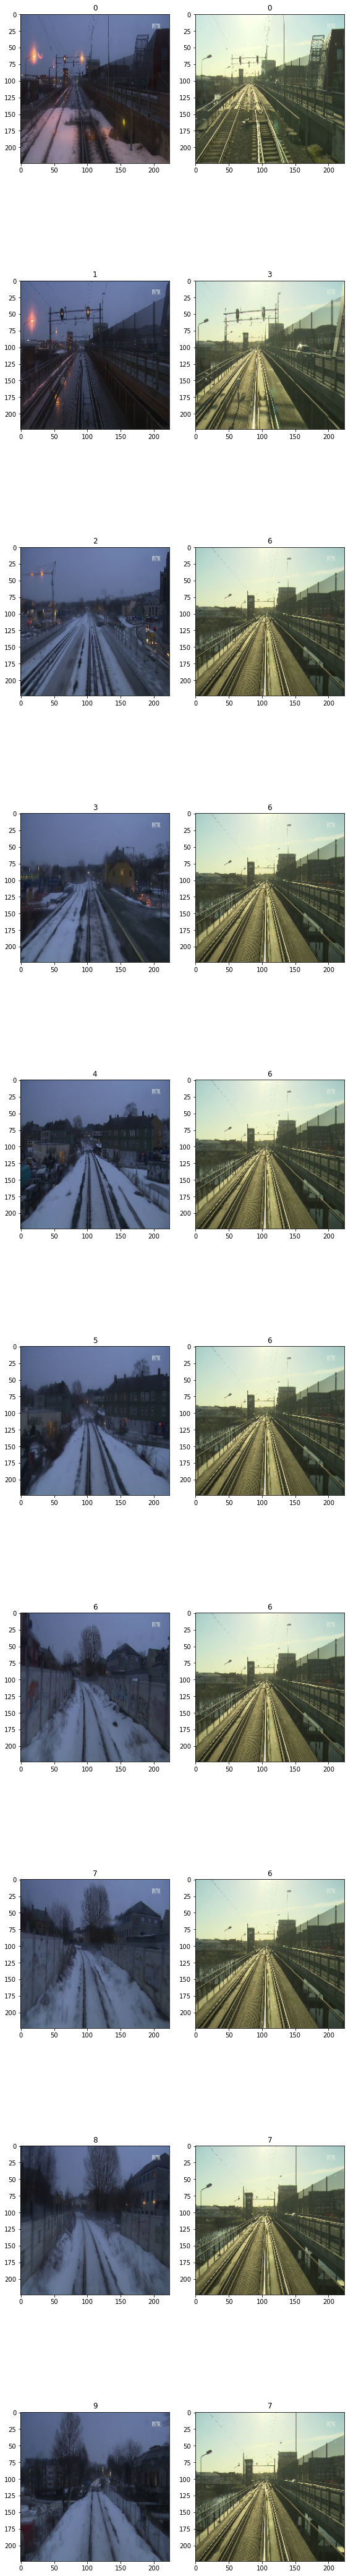

In [11]:
visualize(hog_database_images,hog_query_images,hog_similarity_matrix)

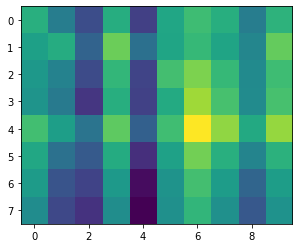

In [12]:
import numpy as np

database = "images/database"
query = "images/query"

database_features,database_images = process_images_from_folder(database)
query_features,query_images = process_images_from_folder(query)

similarity_matrix = np.zeros((len(hog_query_features), len(database_features))) # Q by D

for i in range(len(query_features)):
    for j in range(len(database_features)):
        similarity_matrix[i][j] = get_similarity(query_features[i], database_features[j])

# print(query_features[9])
# print(database_features[9])
# print(similarity_matrix)
plt.imshow(similarity_matrix[:-2])
plt.show()

C:\Users\ranba\AppData\Local\Temp\ipykernel_4240\436049030.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


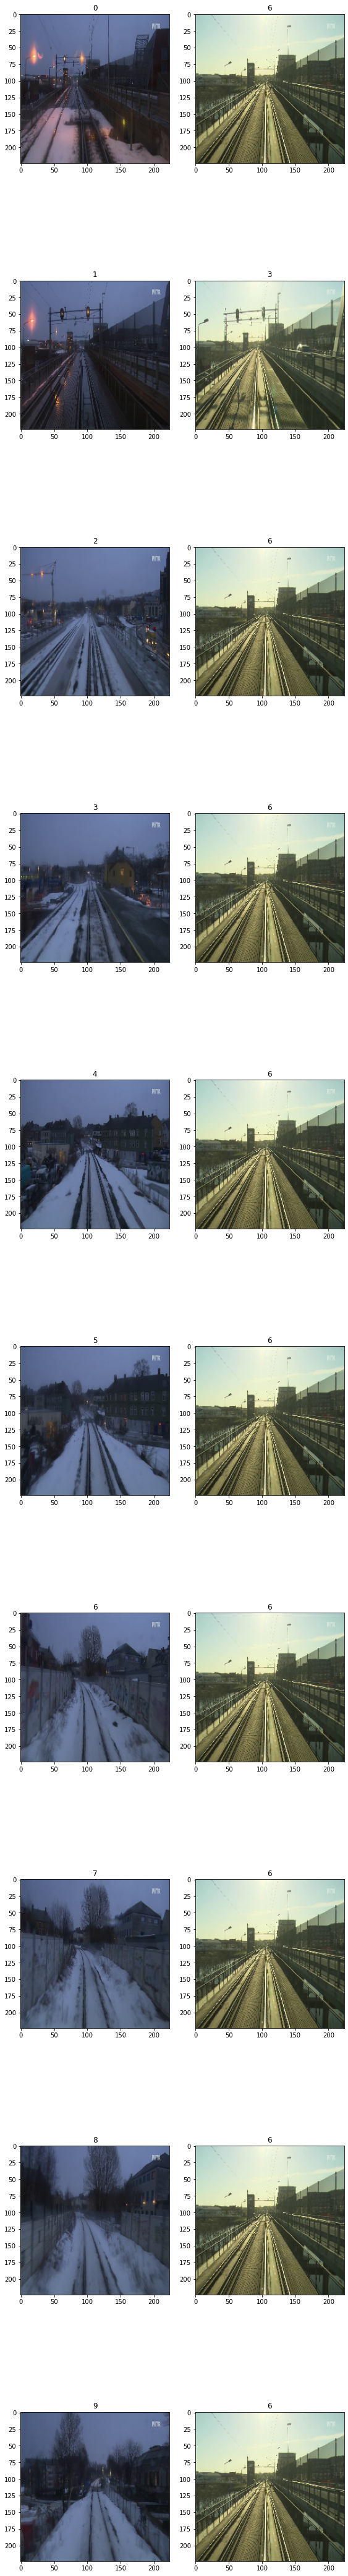

In [13]:
visualize(database_images,query_images,similarity_matrix)

B. Minumum flow

In [14]:
import networkx as nx

In [15]:
# An example of min cost flow
G = nx.DiGraph()
G.add_node("a", demand=-5)
G.add_node("d", demand=5)
G.add_edge("a", "b", weight=3, capacity=4)
G.add_edge("a", "c", weight=6, capacity=10)
G.add_edge("b", "d", weight=1, capacity=9)
G.add_edge("c", "d", weight=2, capacity=5)
flowDict = nx.min_cost_flow(G)
print(flowDict)

{'a': {'b': 4, 'c': 1}, 'd': {}, 'b': {'d': 4}, 'c': {'d': 1}}


In [16]:
# Generate the graph
def minCostFlow(similarity_matrix):
    # Definie our problem
    G = nx.DiGraph()

    # Size of query and data
    Q=similarity_matrix.shape[0]
    D=similarity_matrix.shape[1]

    F=5 # Flow
    K=4 # Span

    w_h = 1 # weight for connecting hidden units

    G.add_node("s", demand=-F)
    G.add_node("t", demand=F)

    # Episolon s
    for j in range(1,D+1):
        G.add_edge("s", (1,j), weight=0, capacity=1)
        G.add_edge("s", (-1,-j), weight=0, capacity=1)

    # Episolon t
    for j in range(1,D+1):
        G.add_edge((Q,j), "t", weight=0, capacity=1)
        G.add_edge((-Q,-j), "t", weight=0, capacity=1)

    # Episolon a and b
    for i in range(1,Q):
        for j in range(1,D+1):
            for k in range(j,min(max(j+K,D),D+1)):
                # print(k)
                G.add_edge((i,j), (i+1,k), weight=1/similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((-i,-j), (-i-1,-k), weight=1/similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((i,j), (-i-1,-k), weight=1/similarity_matrix[i-1][j-1], capacity=1)
                G.add_edge((-i,-j), (i+1,k), weight=1/similarity_matrix[i-1][j-1], capacity=1)
                # G.add_edge((i,j), (i+1,k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((i,j), (-i-1,-k), weight=0, capacity=1)
                # G.add_edge((-i,-j), (i+1,k), weight=0, capacity=1)

    # Episolon h
    for i in range(1,Q+1):
        for j in range(1,D-1):
            G.add_edge((i,j), (i,j+1), weight=0, capacity=1)
            G.add_edge((i,j), (-i,-j-1), weight=0, capacity=1)
            G.add_edge((-i,-j), (i,j+1), weight=0, capacity=1)
            G.add_edge((-i,-j), (-i,-j-1), weight=0, capacity=1)
    return G

In [29]:
G = minCostFlow(similarity_matrix)
print(G.number_of_edges())

# min cost flow solution
flowDict = nx.min_cost_flow(G)
print(flowDict)

2124
{'s': {(1, 1): 1, (-1, -1): 1, (1, 2): 1, (-1, -2): 0, (1, 3): 1, (-1, -3): 1, (1, 4): 0, (-1, -4): 0, (1, 5): 0, (-1, -5): 0, (1, 6): 0, (-1, -6): 0, (1, 7): 0, (-1, -7): 0, (1, 8): 0, (-1, -8): 0, (1, 9): 0, (-1, -9): 0, (1, 10): 0, (-1, -10): 0}, 't': {}, (1, 1): {(2, 1): 0, (-2, -1): 0, (2, 2): 0, (-2, -2): 1, (2, 3): 0, (-2, -3): 0, (2, 4): 1, (-2, -4): 0, (2, 5): 0, (-2, -5): 0, (2, 6): 0, (-2, -6): 0, (2, 7): 0, (-2, -7): 0, (2, 8): 0, (-2, -8): 0, (2, 9): 0, (-2, -9): 0, (1, 2): 0, (-1, -2): 0}, (-1, -1): {(-2, -1): 0, (2, 1): 1, (-2, -2): 0, (2, 2): 0, (-2, -3): 0, (2, 3): 0, (-2, -4): 0, (2, 4): 0, (-2, -5): 0, (2, 5): 0, (-2, -6): 0, (2, 6): 0, (-2, -7): 0, (2, 7): 0, (-2, -8): 0, (2, 8): 0, (-2, -9): 0, (2, 9): 0, (1, 2): 0, (-1, -2): 0}, (1, 2): {(2, 2): 0, (-2, -2): 0, (2, 3): 0, (-2, -3): 0, (2, 4): 0, (-2, -4): 0, (2, 5): 0, (-2, -5): 0, (2, 6): 0, (-2, -6): 0, (2, 7): 0, (-2, -7): 0, (2, 8): 0, (-2, -8): 0, (2, 9): 0, (-2, -9): 0, (1, 3): 1, (-1, -3): 0}, (-1, -2)

In [28]:
if nx.is_directed_acyclic_graph(G):
    print(list(reversed(list(nx.topological_sort(G)))))

['t', (10, 9), (-10, -9), (10, 8), (-10, -8), (10, 7), (-10, -7), (10, 6), (-10, -6), (10, 5), (-10, -5), (10, 4), (-10, -4), (10, 3), (-10, -3), (10, 2), (-10, -2), (10, 1), (-10, -1), (10, 10), (-10, -10), (9, 9), (-9, -9), (9, 8), (-9, -8), (9, 7), (-9, -7), (9, 6), (-9, -6), (9, 5), (-9, -5), (9, 4), (-9, -4), (9, 3), (-9, -3), (9, 2), (-9, -2), (9, 1), (-9, -1), (9, 10), (-9, -10), (8, 9), (-8, -9), (8, 8), (-8, -8), (8, 7), (-8, -7), (8, 6), (-8, -6), (8, 5), (-8, -5), (8, 4), (-8, -4), (8, 3), (-8, -3), (8, 2), (-8, -2), (8, 1), (-8, -1), (8, 10), (-8, -10), (7, 9), (-7, -9), (7, 8), (-7, -8), (7, 7), (-7, -7), (7, 6), (-7, -6), (7, 5), (-7, -5), (7, 4), (-7, -4), (7, 3), (-7, -3), (7, 2), (-7, -2), (7, 1), (-7, -1), (7, 10), (-7, -10), (6, 9), (-6, -9), (6, 8), (-6, -8), (6, 7), (-6, -7), (6, 6), (-6, -6), (6, 5), (-6, -5), (6, 4), (-6, -4), (6, 3), (-6, -3), (6, 2), (-6, -2), (6, 1), (-6, -1), (6, 10), (-6, -10), (5, 9), (-5, -9), (5, 8), (-5, -8), (5, 7), (-5, -7), (5, 6), (-

In [61]:
def visualizeList(database_images,query_images,shortest_list):
    query_num = len(shortest_list)-2
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize= (8,60)) 
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[shortest_list[i+1][1]-1])
        ax[i, 1].set_title(shortest_list[i+1][1]-1)
    fig.show()

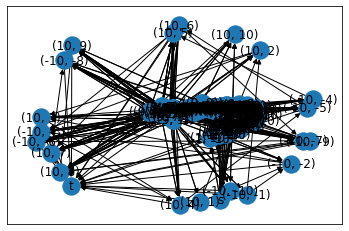

In [23]:
nx.draw_networkx(G)
# nx.write_gexf(G, "test.gexf")

In [44]:
# for u in flowDict:
#     for v in flowDict[u]:
#         if flowDict[u][v]>0:
#             print(u,v)

list_flow = [(u, v) for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]

['s', (1, 1), (2, 4), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (10, 7), 't']


C:\Users\ranba\AppData\Local\Temp\ipykernel_4240\1001742262.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


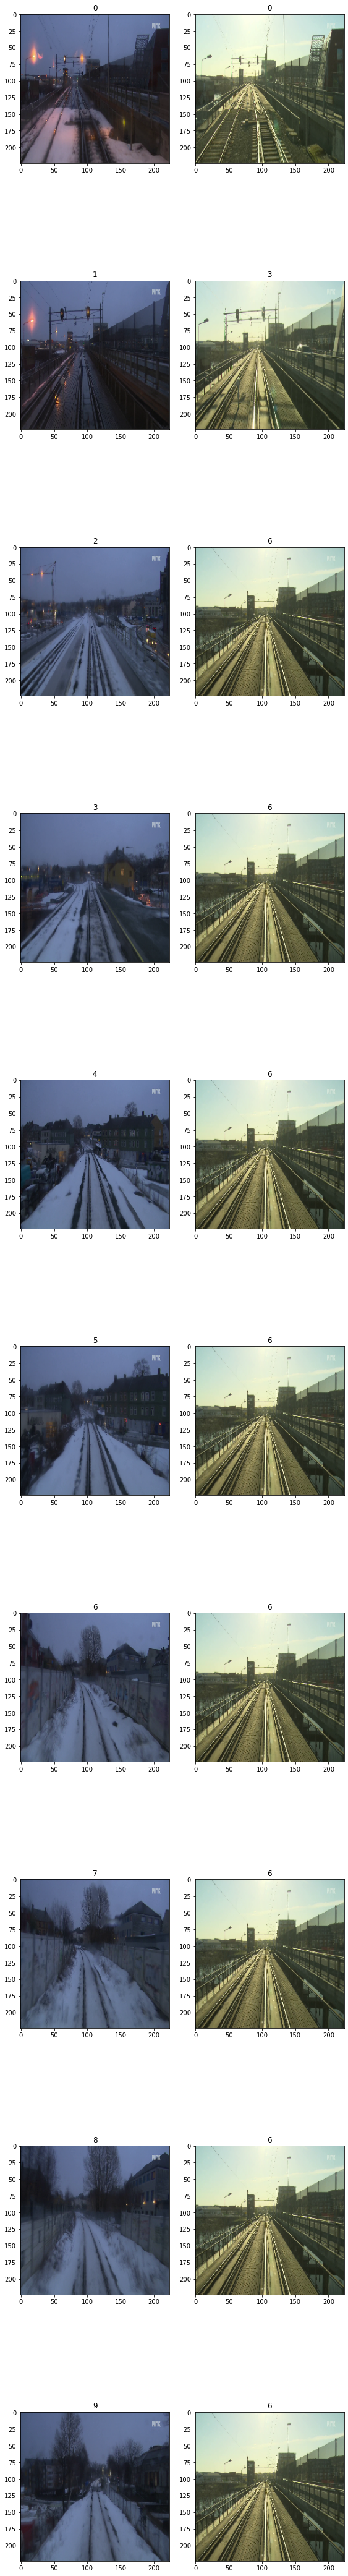

In [62]:
shortest_list = nx.shortest_path(G, "s", "t", weight="weight")
print(shortest_list)

visualizeList(database_images,query_images,shortest_list)

In [26]:
flowDict.keys()

dict_keys(['s', 't', (1, 1), (-1, -1), (1, 2), (-1, -2), (1, 3), (-1, -3), (1, 4), (-1, -4), (1, 5), (-1, -5), (1, 6), (-1, -6), (1, 7), (-1, -7), (1, 8), (-1, -8), (1, 9), (-1, -9), (1, 10), (-1, -10), (10, 1), (-10, -1), (10, 2), (-10, -2), (10, 3), (-10, -3), (10, 4), (-10, -4), (10, 5), (-10, -5), (10, 6), (-10, -6), (10, 7), (-10, -7), (10, 8), (-10, -8), (10, 9), (-10, -9), (10, 10), (-10, -10), (2, 1), (-2, -1), (2, 2), (-2, -2), (2, 3), (-2, -3), (2, 4), (-2, -4), (2, 5), (-2, -5), (2, 6), (-2, -6), (2, 7), (-2, -7), (2, 8), (-2, -8), (2, 9), (-2, -9), (2, 10), (-2, -10), (3, 1), (-3, -1), (3, 2), (-3, -2), (3, 3), (-3, -3), (3, 4), (-3, -4), (3, 5), (-3, -5), (3, 6), (-3, -6), (3, 7), (-3, -7), (3, 8), (-3, -8), (3, 9), (-3, -9), (3, 10), (-3, -10), (4, 1), (-4, -1), (4, 2), (-4, -2), (4, 3), (-4, -3), (4, 4), (-4, -4), (4, 5), (-4, -5), (4, 6), (-4, -6), (4, 7), (-4, -7), (4, 8), (-4, -8), (4, 9), (-4, -9), (4, 10), (-4, -10), (5, 1), (-5, -1), (5, 2), (-5, -2), (5, 3), (-5, 